In [140]:
require(tidyverse)
require(data.table)
require(ggplot2)
require(chromVAR)
require(extrafont)# fonts 
#https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249,249,212,maxColorValue = 255),
                                     rgb(60,181,195,maxColorValue = 255),
                                     rgb(30,35,86,maxColorValue = 255)),
                                   space="Lab")

require(ggpubr)

## 1. chromVar

### 1.1 select variable motifs

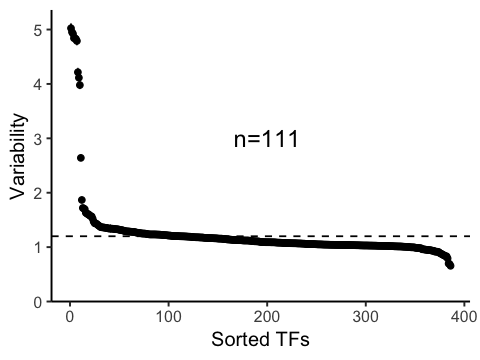

In [72]:
options(repr.plot.width=4, repr.plot.height=3)
variability <- read.csv("../dat/output.jaspar.var.res.csv",row.names=1)
plotVariability(variability, use_plotly = FALSE,labels = "",)+
    geom_hline(yintercept = 1.2,linetype=2)+
    annotate("text",x=200,y=3,
             label=paste0('n=',nrow(subset(variability,variability>=1.2))),
            family = "Arial",size=5)+
theme(text = element_text(family = "Arial"))
ggsave(filename = "fig_s1.select_varible_motifs.pdf",width = 4,height = 3,useDingbats=F)

### 1.2 Select subtype variable motifs

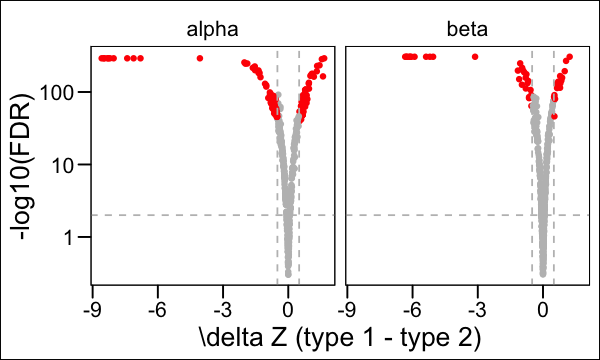

In [74]:
options(repr.plot.width=5, repr.plot.height=3)

ttest.res.pd <- fread("../dat/ttest.res.csv")%>%
  group_by(celltype)%>%
  mutate(min.FDR = min(FDR[FDR!=0]),
         FDR.bak =FDR)%>%
  mutate(FDR=ifelse(FDR==0,min.FDR,FDR))%>%
filter(celltype!="delta")

plt.volcano.ttest <- ggplot(ttest.res.pd,
       aes(delta,-log10(FDR)))+
  geom_point(aes(color=selected),
             shape=ifelse(ttest.res.pd$FDR< ttest.res.pd$min.FDR,17,16))+
  theme_base()+
  geom_hline(yintercept = 2,linetype=2,color='grey')+
  geom_vline(xintercept = c(-.5,.5),linetype=2,color='grey')+
  scale_y_log10()+
  scale_color_manual(values = c("grey","red"))+
  theme(legend.position = "none")+
  facet_wrap(~celltype)+
  xlab("\\delta Z (type 1 - type 2)")

  print(plt.volcano.ttest)
  ggsave(filename ="fig_s2.select_subtype_motifs.pdf",width = 5,height = 3,,useDingbats=F)

### 1.3 plot motif heatmap for alpha and beta cells

quartz_off_screen 
                2

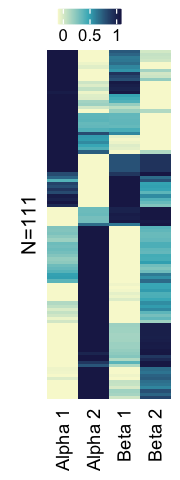

In [137]:
options(repr.plot.width=1.5, repr.plot.height=4)

#calc_varability_heatmap_on_subtypes_ab.R
pd.fig_2B.motif_heatmap_ab <- read.csv("./fig_2B.motif_heatmap_ab.csv",row.names=1)
colnames(pd.fig_2B.motif_heatmap_ab) <- c("Alpha 1","Alpha 2","Beta 1","Beta 2")
ht <- Heatmap(pd.fig_2B.motif_heatmap_ab,
        col=cols.hm.avg.tf(30),cluster_columns = F,cluster_rows = F,
        row_title = paste0("N=",nrow(pd.fig_2B.motif_heatmap_ab)),
        row_title_side ="left",
        row_title_gp = gpar(fontsize = 12),
        show_column_names = T,show_row_names = F,
        column_names_gp = gpar(fontsize = 11),
        name = "",show_heatmap_legend = T,
        heatmap_legend_param = list(at = c(0,0.5,1), 
                                    title_gp = gpar(fontsize = 9),
                                   grid_border="black",
                                    color_bar="continuous",
                                    grid_height = unit(3, "mm"),
                                   legend_direction="horizontal"),
        show_row_dend = F,combined_name_fun = NULL)
draw(ht, heatmap_legend_side = "top")
pdf("fig_2B.motif_heatmap_ab.pdf",height = 4,width = 2,family = "Arial")
draw(ht, heatmap_legend_side = "top")
dev.off()

### 1.4 violin plot for motif (between celltypes)

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

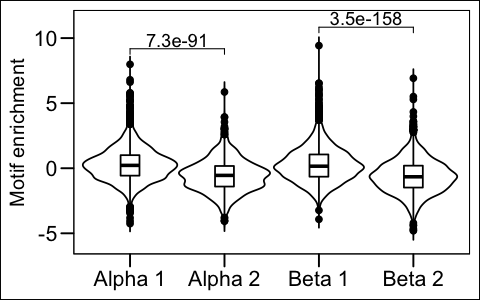

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”

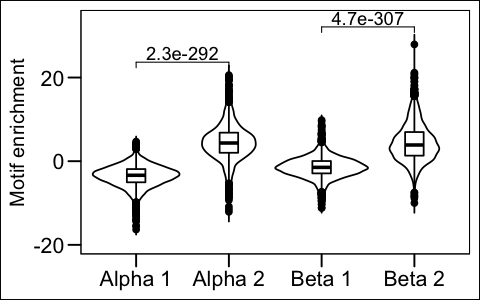

In [216]:
pd.fig_2B.motif_violin_ab <- fread(file = '../figcode/fig_2B.motif_violin_ab.csv')%>%
    mutate(cluster=factor(cluster,levels = c("Alpha 1","Alpha 2","Beta 1", "Beta 2")))

options(repr.plot.width=4, repr.plot.height=2.5)
fun.plotMofifGG <- function(m){
        pd <- pd.fig_2B.motif_violin_ab%>%
                filter(Motif.name==m)
    pd.m <- pd%>%ungroup()%>%
    group_by(cluster)%>%
    summarise(mmin=min(zval),mmax=max(zval))%>%
    as.data.frame()%>%
    column_to_rownames("cluster")
    mmin<- min(pd$zval);mmax<- max(pd$zval)
        ggviolin(pd,
              x = "cluster",y = "zval",add = "boxplot",ylab="Motif enrichment") + 
    theme_base()+ 
    stat_pvalue_manual(data = ttest.res.pd%>%filter(motif==m)%>%
            ungroup()%>%
        mutate(group1=c("Alpha 1","Beta 1"),
          group2=c("Alpha 2","Beta 2"),
        FDR=signif(FDR,2),
        y.position=c(max(pd.m[c("Alpha 1","Alpha 2"),"mmax"])*1.15,
                    max(pd.m[c("Beta 1","Beta 2"),"mmax"])*1.15)), label = "FDR",
        xmin = "group1", xmax = "group2",
        y.position = "y.position")+
    coord_cartesian(expand = T,ylim = c(mmin*1.2,mmax*1.2))+
    theme(legend.position = "none",axis.title.x = element_blank(),
          title = element_text(size = 12,hjust = 0.5),
          text = element_text(family = "Arial"))
}

fun.plotMofifGG("RFX3")
ggsave(filename ="fig_2B.motif_violin_ab_RFX3.pdf",width = 4,height = 2.5,,useDingbats=F)
fun.plotMofifGG("FOS::JUN")
ggsave(filename ="fig_2B.motif_violin_ab_FOS_JUN.pdf",width = 4,height = 2.5,,useDingbats=F)

fun.plotMofifGG("XBP1")
ggsave(filename ="fig_2B.motif_violin_ab_XBP1.pdf",width = 4,height = 2.5,,useDingbats=F)


### 1.5 UMAP scatter